In [2]:
import os
import parse
import fasttext
import numpy as np
from sklearn.metrics import f1_score

datadir = "/home/peterr/macocu/task5_webgenres/data/final/fasttext1"


def parse_test_file(path: str):
    """Reads fasttext formatted file and returns labels, texts."""
    with open(path, "r") as f:
        content = f.readlines()
    pattern = "{label} {text}\n"
    p = parse.compile(pattern)

    labels, texts = list(), list()
    for line in content:
        rez = p.parse(line)
        labels.append(rez["label"])
        texts.append(rez["text"])
    return labels, texts

def prediction_to_label(prediction):
    """Transforms predicitons as returned by fasttext into pure labels."""
    import numpy as np
    return np.array(prediction[0])[:, 0]

all_labels = [
 '__label__Promotion_of_Services',
 '__label__Instruction',
 '__label__Review',
 '__label__Information/Explanation',
 '__label__Promotion_of_a_Product',
 '__label__News/Reporting',
 '__label__Promotion',
 '__label__Announcement',
 '__label__Invitation',
 '__label__Opinion/Argumentation',
 '__label__Forum',
 '__label__Legal/Regulation',
 '__label__Other',
 '__label__Opinionated_News',
 '__label__Call',
 '__label__List_of_Summaries/Excerpts']


# first experiment with paragraphs - compare using all text vs. using only non-duplicates (Q1)

In [25]:
dev_keep = os.path.join(datadir, "dev_onlykeep_True_onlyprimary_True.fasttext")
test_keep = os.path.join(datadir, "test_onlykeep_True_onlyprimary_True.fasttext")
train_keep = os.path.join(datadir, "train_onlykeep_True_onlyprimary_True.fasttext")

dev_nokeep = os.path.join(datadir, "dev_onlykeep_False_onlyprimary_True.fasttext")
test_nokeep = os.path.join(datadir, "test_onlykeep_False_onlyprimary_True.fasttext")
train_nokeep = os.path.join(datadir, "train_onlykeep_False_onlyprimary_True.fasttext")

model_keep = fasttext.train_supervised(input=train_keep, autotuneValidationFile=dev_keep, autotuneDuration=1200)

model_nokeep = fasttext.train_supervised(input=train_nokeep, autotuneValidationFile=dev_nokeep, autotuneDuration=1200)

In [26]:
modeldir = "/home/peterr/macocu/task5_webgenres/data/models/experiment1"
model_keep.save_model(os.path.join(modeldir, "model_onlykeep_onlyprimary.bin"))
model_nokeep.save_model(os.path.join(modeldir, "model_all_onlyprimary.bin"))

In [27]:
y_true_keep, texts_keep = parse_test_file(test_keep)
y_true_nokeep, texts_nokeep = parse_test_file(test_nokeep)

y_pred_keep = model_keep.predict(texts_keep)
y_pred_nokeep = model_nokeep.predict(texts_nokeep)

y_pred_keep = prediction_to_label(y_pred_keep)
y_pred_nokeep = prediction_to_label(y_pred_nokeep)

microF1=0.3678
macroF1=0.2661


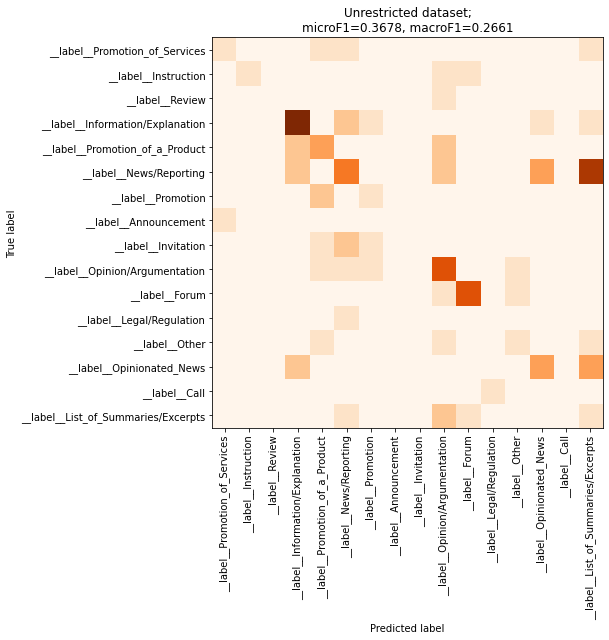

microF1=0.3626
macroF1=0.2664


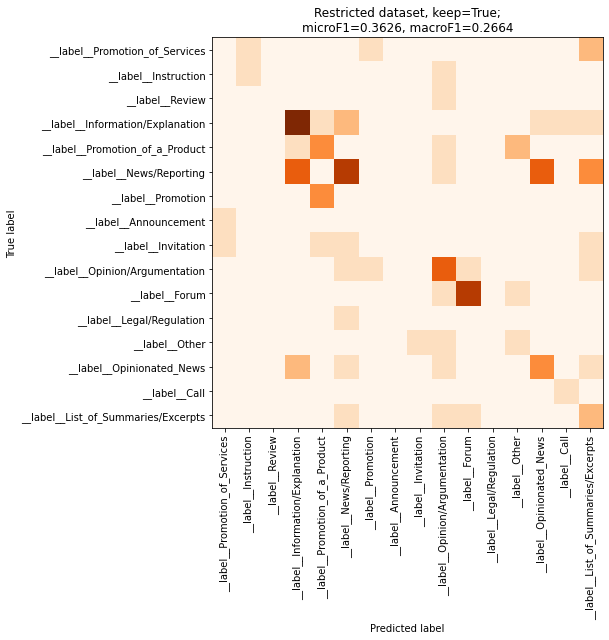

In [28]:
def plot_cm(y_true, y_pred, labels, save=False, title=None):
    from sklearn.metrics import confusion_matrix
    from sklearn.metrics import f1_score
    import matplotlib.pyplot as plt
    cm = confusion_matrix(y_true, y_pred, labels=labels, )
    plt.figure(figsize=(9, 9))
    plt.imshow(cm, cmap="Oranges")
    classNames = labels
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    tick_marks = np.arange(len(classNames))
    plt.xticks(tick_marks, classNames, rotation=90)
    plt.yticks(tick_marks, classNames)
    microF1 = f1_score(y_true, y_pred, labels=labels, average ="micro")
    macroF1 = f1_score(y_true, y_pred, labels=labels, average ="macro")

    print(f"{microF1=:0.4}")
    print(f"{macroF1=:0.4}")

    metrics = f"{microF1=:0.4}, {macroF1=:0.4}"
    if title:
        plt.title(title +";\n" + metrics)
    else:
        plt.title(metrics)
    plt.tight_layout()
    if save:
        plt.savefig(save)
    plt.show()



plot_cm(y_true_nokeep, y_pred_nokeep, all_labels, save="images/experiment1_keepall.png", title="Unrestricted dataset")
plot_cm(y_true_keep, y_pred_keep, all_labels, save="images/experiment1_onlykeep.png", title="Restricted dataset, keep=True")

microF1=0.3699
macroF1=0.2512


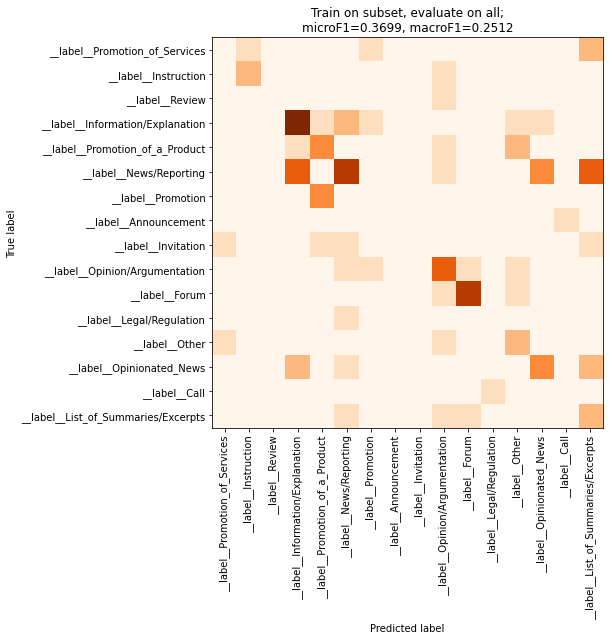

microF1=0.3333
macroF1=0.1694


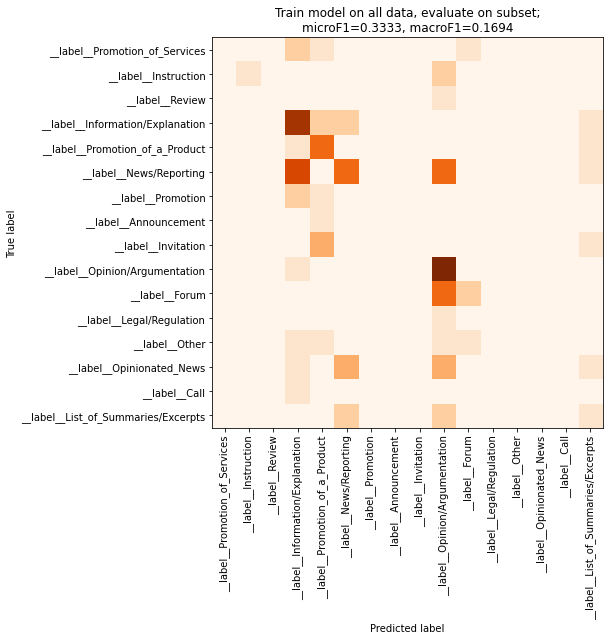

In [29]:
plot_cm(y_true_nokeep, y_pred_nokeep_on_keep_model, all_labels, 
            save="images/experiment1_train_on_subset_evaluate_on_all.png", 
            title="Train on subset, evaluate on all")
plot_cm(y_true_keep, y_pred_keep_on_nokeep_model, all_labels, 
            save="images/experiment1_train_on_all_evaluate_on_subset.png", 
            title="Train model on all data, evaluate on subset")

In [30]:
y_true_keep, texts_keep = parse_test_file(test_keep)
y_true_nokeep, texts_nokeep = parse_test_file(test_nokeep)

y_pred_nokeep_on_keep_model = model_keep.predict(texts_nokeep)
y_pred_keep_on_nokeep_model = model_nokeep.predict(texts_keep)

y_pred_keep_on_nokeep_model = prediction_to_label(y_pred_keep_on_nokeep_model)
y_pred_nokeep_on_keep_model = prediction_to_label(y_pred_nokeep_on_keep_model)

# Preparation for distribution based classification

In [31]:
prediction = model_keep.predict("Naša hiša ima dimnik", k = -1) # Need -1 here to output all labels

prediction_dictionary ={ key: value for key, value in zip(*prediction)}
distribution = [prediction_dictionary[key] for key in all_labels]
distribution

[3.542230115272105e-05,
 2.6591073037707247e-05,
 1.0045443559647538e-05,
 1.0000003385357559e-05,
 1.2211198736622464e-05,
 3.0259894629125483e-05,
 0.0002275675506098196,
 2.8405538614606485e-05,
 0.01199095044285059,
 1.0001157534134109e-05,
 5.679078822140582e-05,
 1.0005059266404714e-05,
 0.9876322150230408,
 1.0000003385357559e-05,
 1.0758949429146014e-05,
 1.000013708107872e-05]

In [32]:
y_true = [
    [1,1,0,0],
    [1,0,1,1],
    [1,0,0,0],
    [0,1,1,0]
]
y_pred = [
    [1,1,0,0],
    [1,1,1,1],
    [1,1,0,0],
    [0,0,1,0]
]

f1_score(y_true, y_pred, average="macro")

NameError: name 'f1_score' is not defined